# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

### Load Data

In [2]:
def nz_interpolate(source, n):
    # Extract the zgrid and photo_hists from source_0
    znodes = source['znodes']
    photo_hists = source['photo_hists']
    dz = znodes[1] - znodes[0]

    # Create an interpolation function
    print(znodes.shape, photo_hists.shape)
    interp_func = interp1d(znodes, photo_hists, kind='cubic', axis=0)

    # Define the new zgrid with 1000 nodes
    new_znodes = np.linspace(znodes.min(), znodes.max(), n)
    new_dz = new_znodes[1] - new_znodes[0]
    new_zgrid = np.append([new_znodes[0] - new_dz/2], new_znodes + new_dz/2)

    # Interpolate the photo_hists to the new zgrid
    new_photo_hists = interp_func(new_znodes)
    new_source = {'znodes': new_znodes, 
                  'zgrid': new_zgrid,
                  'photo_hists': new_photo_hists}
    return new_source

In [3]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Ensembles
method = "bpz"
source_0 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_0.npz'.format(method), allow_pickle=True)
source_1 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_1.npz'.format(method), allow_pickle=True)
source_2 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_2.npz'.format(method), allow_pickle=True)
source_3 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_3.npz'.format(method), allow_pickle=True)
source_4 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_4.npz'.format(method), allow_pickle=True)

lens_0 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/lens_0.npz'.format(method), allow_pickle=True)
lens_1 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/lens_1.npz'.format(method), allow_pickle=True)
lens_2 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/lens_2.npz'.format(method), allow_pickle=True)
lens_3 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/lens_3.npz'.format(method), allow_pickle=True)
lens_4 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/lens_4.npz'.format(method), allow_pickle=True)

# Interpolated nz
source_0 = nz_interpolate(source_0, 1000)
source_1 = nz_interpolate(source_1, 1000)
source_2 = nz_interpolate(source_2, 1000)
source_3 = nz_interpolate(source_3, 1000)
source_4 = nz_interpolate(source_4, 1000)

lens_0 = nz_interpolate(lens_0, 1000)
lens_1 = nz_interpolate(lens_1, 1000)
lens_2 = nz_interpolate(lens_2, 1000)
lens_3 = nz_interpolate(lens_3, 1000)
lens_4 = nz_interpolate(lens_4, 1000)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)
(25,) (25, 1000)


In [4]:
#cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
#pacc.plot_cls([cle], cle.pairs)

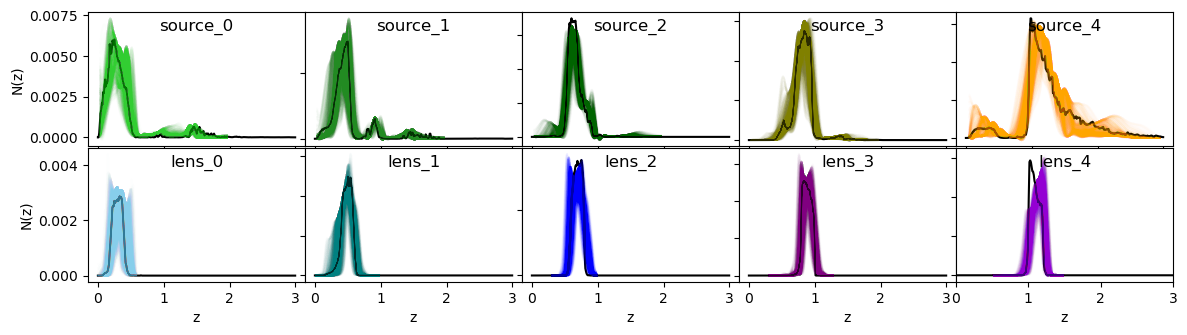

In [5]:
figure, axis = plt.subplots(2, 5, figsize=(14, 3.5))
figure.subplots_adjust(wspace=0, hspace=0.01)

colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[0, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[0, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[0, i].set_title(key, y=0.8)
    axis[0, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[1, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[1, i].set_title(key, y=0.8)
    axis[1, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')
        axis[1, i].set_ylabel('N(z)')
    else:
        axis[0, i].set_yticklabels([])
        axis[1, i].set_yticklabels([])

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.show()

In [6]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.01])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

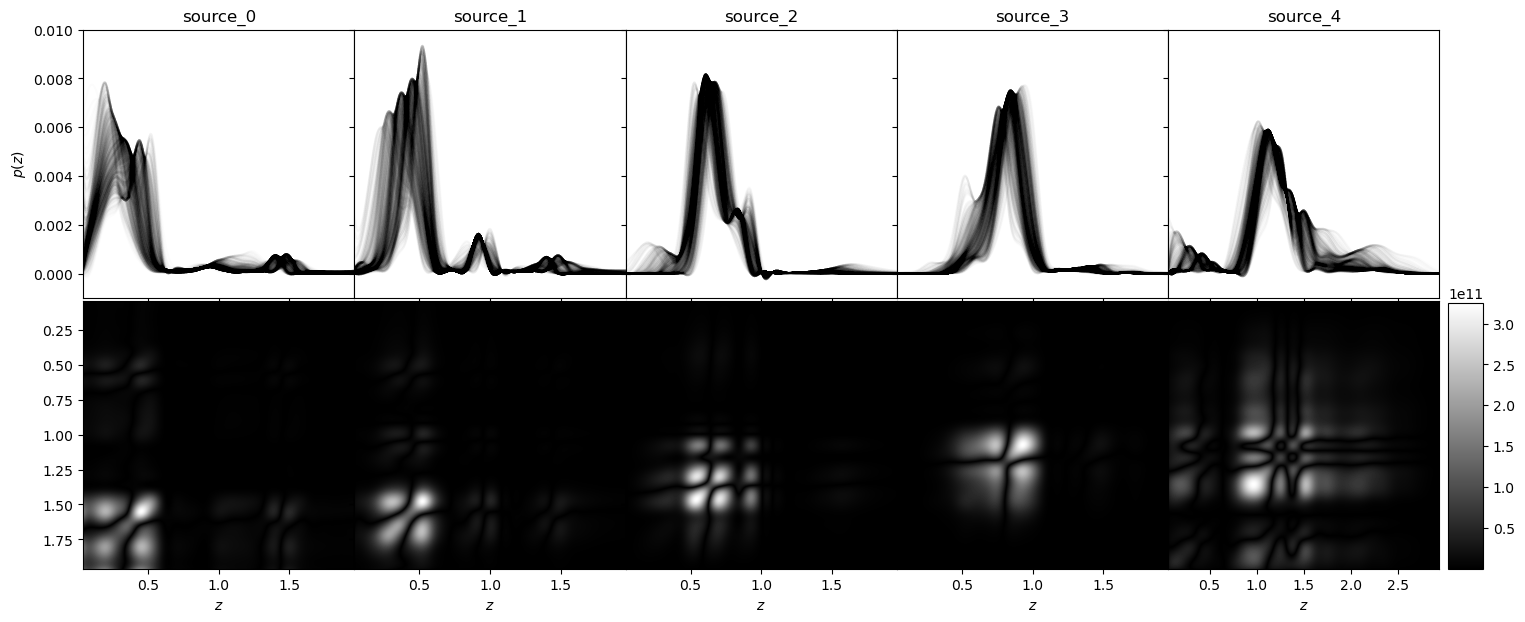

In [7]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

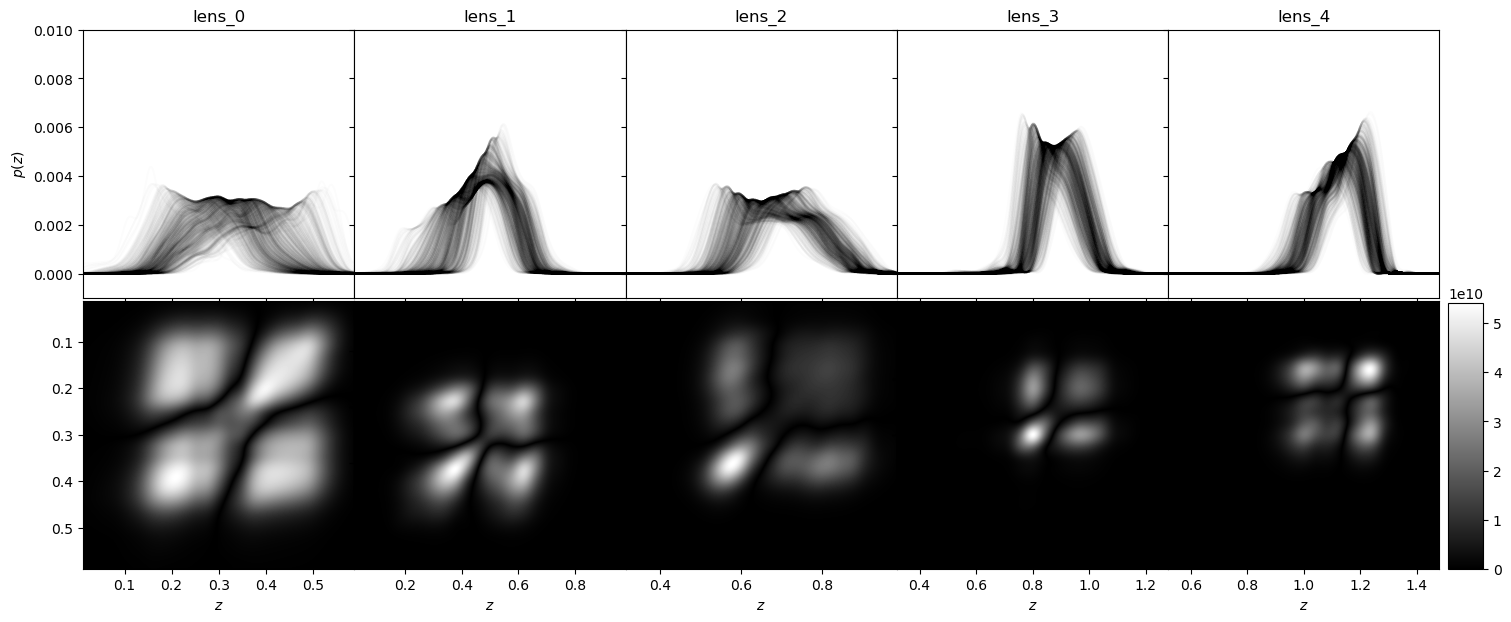

In [8]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [9]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

In [10]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.001, 0.01])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

## Shifts

In [11]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [12]:
shifts_priors.sample_prior()

{np.str_('source_0__delta_z'): np.float64(-0.008848398857188805),
 np.str_('source_1__delta_z'): np.float64(-0.0007168856140520563),
 np.str_('source_2__delta_z'): np.float64(0.0036386115246158815),
 np.str_('source_3__delta_z'): np.float64(-0.005106745892368303),
 np.str_('source_4__delta_z'): np.float64(0.02429961752902583),
 np.str_('lens_0__delta_z'): np.float64(0.01238728774045843),
 np.str_('lens_1__delta_z'): np.float64(0.02396321292198639),
 np.str_('lens_2__delta_z'): np.float64(0.01756195993096065),
 np.str_('lens_3__delta_z'): np.float64(0.018640101944310178),
 np.str_('lens_4__delta_z'): np.float64(0.015118580200967575)}

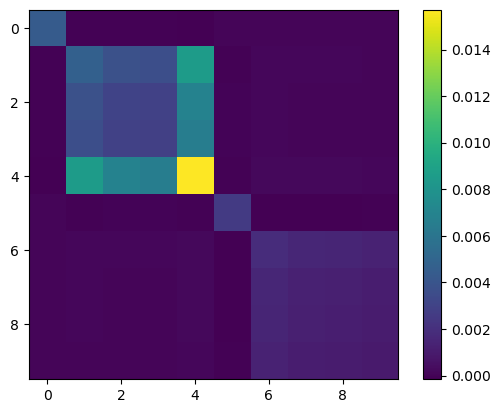

In [13]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [14]:
mean, cov, chol = shifts_priors.get_prior()
file_name = "dz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)

In [15]:
shifted_nzs = {}
for i in range(500):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_model(nz_fid, params[0])[1]
        if i == 0:
            shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


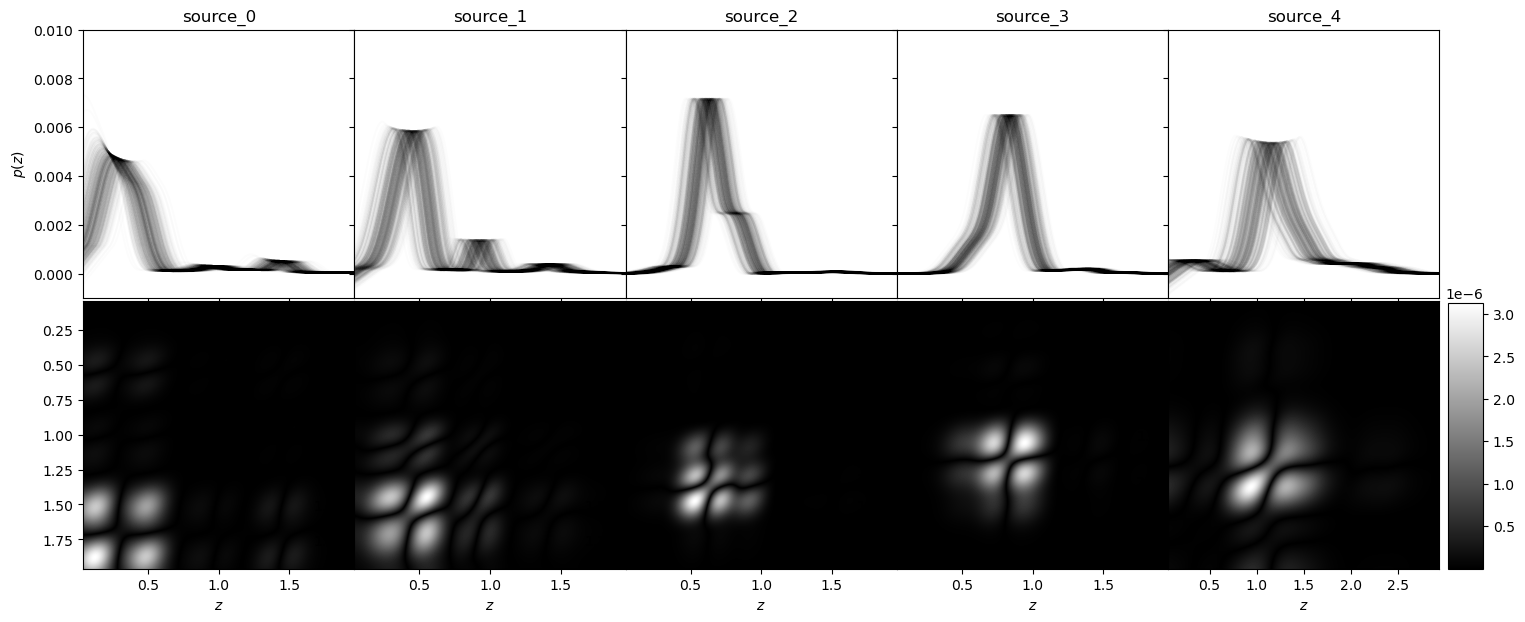

In [16]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

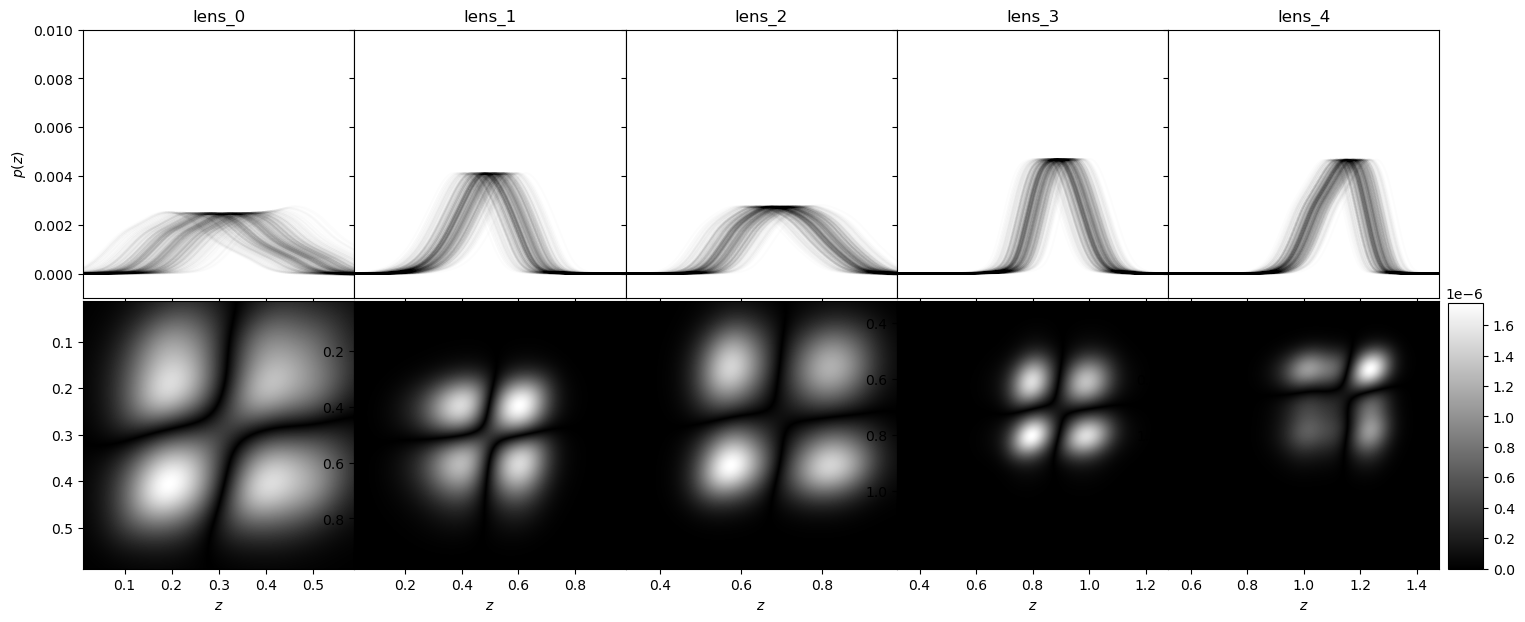

In [17]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [18]:
#shifts_Ds = {}
#for tracer_name in shifted_nzs.keys():
#    model_obj = shifts_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = shifted_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    shifts_Ds[tracer_name] = np.abs(D)

## Shifts & widths

In [19]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs="Full")

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [20]:
SnWs_priors.sample_prior()

{np.str_('source_0__delta_z'): np.float64(0.03843423181079342),
 np.str_('source_0__width_z'): np.float64(1.062464244703899),
 np.str_('source_1__delta_z'): np.float64(0.12538211502865482),
 np.str_('source_1__width_z'): np.float64(1.1255937957659936),
 np.str_('source_2__delta_z'): np.float64(0.09489895742855421),
 np.str_('source_2__width_z'): np.float64(1.1472809334332816),
 np.str_('source_3__delta_z'): np.float64(0.09476178481970288),
 np.str_('source_3__width_z'): np.float64(0.9929212635508706),
 np.str_('source_4__delta_z'): np.float64(0.2056924355838474),
 np.str_('source_4__width_z'): np.float64(1.0587176493878647),
 np.str_('lens_0__delta_z'): np.float64(-0.03246748478595084),
 np.str_('lens_0__width_z'): np.float64(0.9549869760227457),
 np.str_('lens_1__delta_z'): np.float64(0.003067714156333373),
 np.str_('lens_1__width_z'): np.float64(1.0308039290403055),
 np.str_('lens_2__delta_z'): np.float64(0.005392108513192951),
 np.str_('lens_2__width_z'): np.float64(0.99525061322416

In [21]:
mean, cov, chol = SnWs_priors.get_prior()
file_name = "wzdz_prior.npz"
save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_wzdz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov, chol=chol)


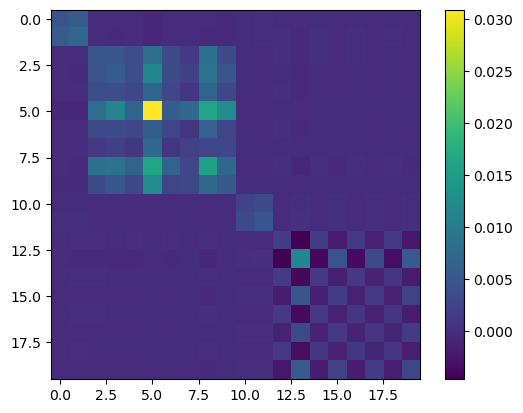

In [22]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [23]:
SnWs_priors.params_names    

array(['source_0__delta_z', 'source_0__width_z', 'source_1__delta_z',
       'source_1__width_z', 'source_2__delta_z', 'source_2__width_z',
       'source_3__delta_z', 'source_3__width_z', 'source_4__delta_z',
       'source_4__width_z', 'lens_0__delta_z', 'lens_0__width_z',
       'lens_1__delta_z', 'lens_1__width_z', 'lens_2__delta_z',
       'lens_2__width_z', 'lens_3__delta_z', 'lens_3__width_z',
       'lens_4__delta_z', 'lens_4__width_z'], dtype='<U17')

In [24]:
SnWs_priors.get_prior()

(array([-4.56301663e-17,  1.00000000e+00, -4.66293670e-17,  1.00000000e+00,
         7.93809463e-17,  1.00000000e+00, -2.05391260e-17,  1.00000000e+00,
        -1.71196390e-16,  1.00000000e+00, -1.86239912e-17,  1.00000000e+00,
        -1.64313008e-17,  1.00000000e+00, -5.77315973e-18,  1.00000000e+00,
        -4.99600361e-18,  1.00000000e+00,  2.57571742e-17,  1.00000000e+00]),
 array([[ 4.41340877e-03,  5.61912792e-03, -7.70638126e-05,
         -1.77363592e-04, -6.24010251e-05, -4.98574123e-04,
         -4.76642067e-05, -1.29279040e-04, -1.60129068e-04,
         -2.03764215e-04,  6.05575434e-05,  1.44368410e-04,
          7.87128420e-05, -1.78319121e-04,  6.52210474e-05,
         -7.05421205e-05,  6.17282762e-05, -6.11134009e-05,
          5.86568022e-05, -9.09175628e-05],
        [ 5.61912792e-03,  7.40558839e-03, -1.20851886e-04,
         -2.59172856e-04, -9.84184283e-05, -7.16065629e-04,
         -7.74971424e-05, -1.80154946e-04, -2.46616804e-04,
         -2.97091132e-04,  8.07656

In [25]:
SnWs_nzs = {}
for i in range(500):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]


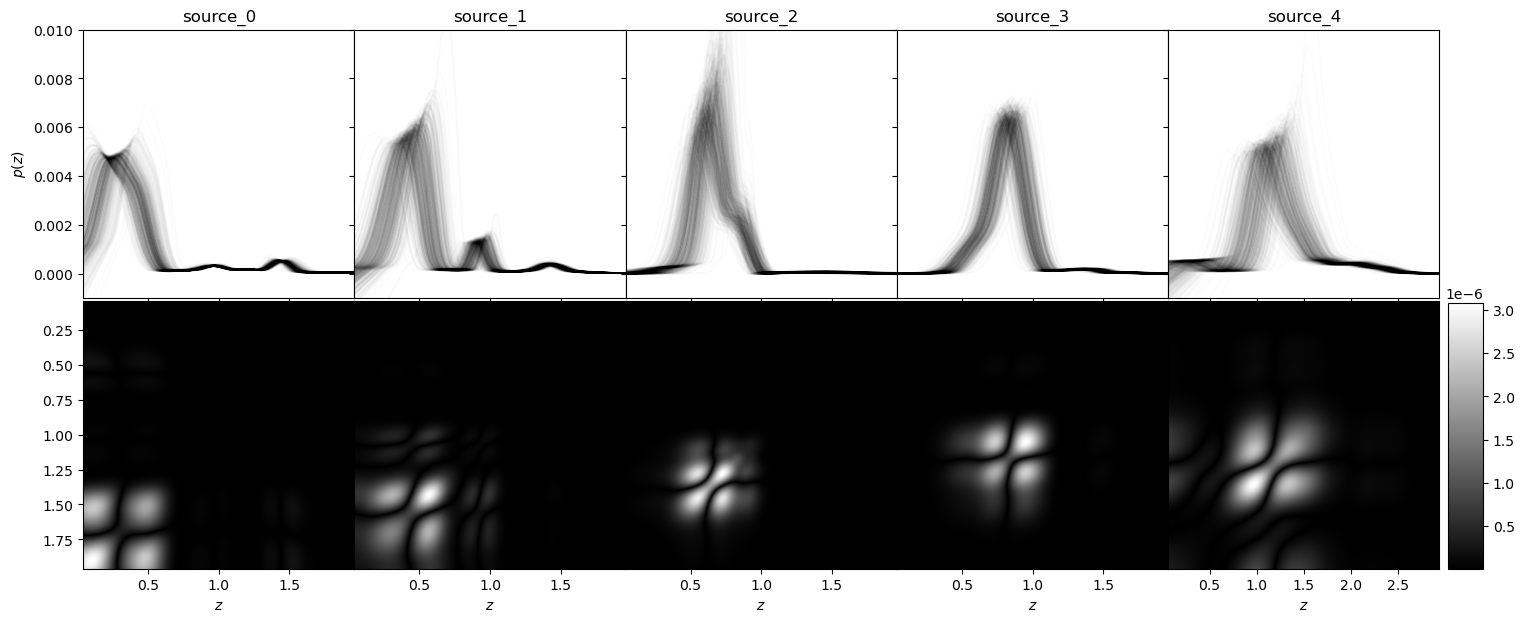

In [26]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

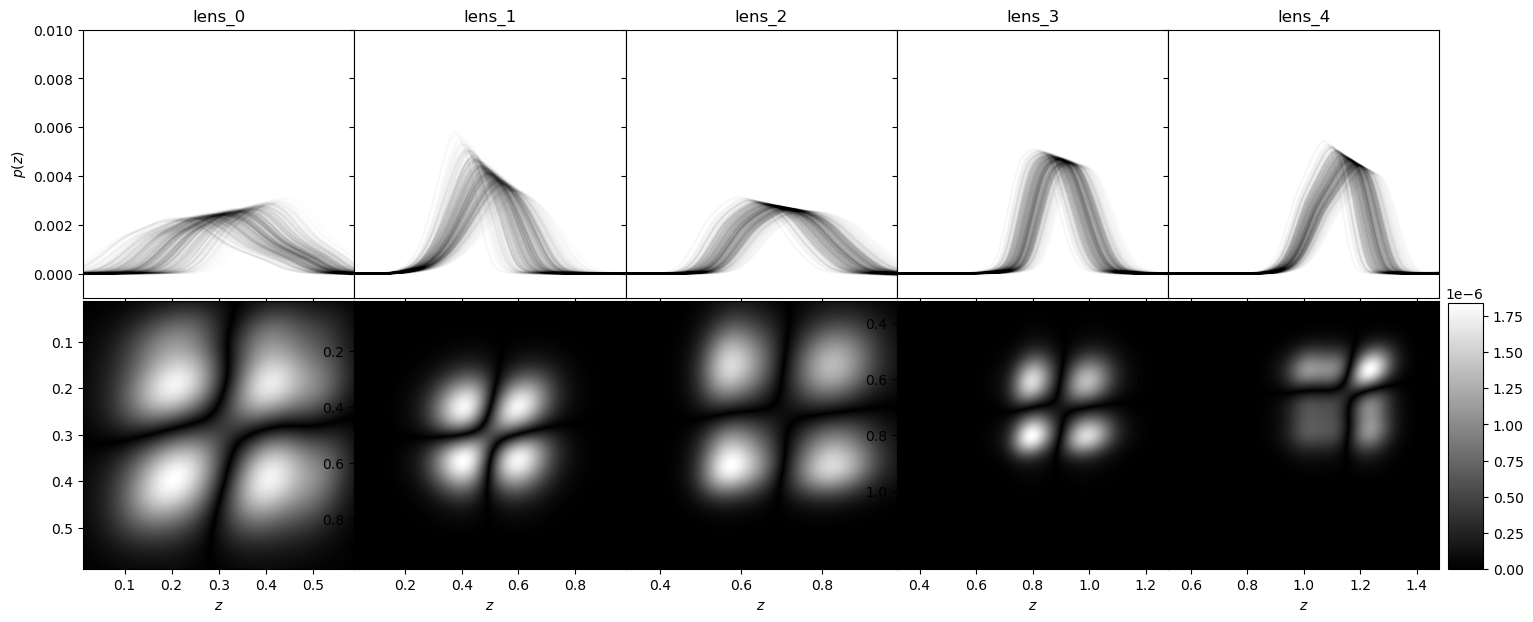

In [27]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [28]:
#SnWs_Ds = {}
#for tracer_name in SnWs_nzs.keys():
#    model_obj = SnWs_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = SnWs_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    SnWs_Ds[tracer_name] = np.abs(D)

## GP

In [29]:
n = 10
gp_priors = nzp.PriorSacc(
    ss_qp,
    model="GP",
    compute_crosscorrs=crosscorrs_method,
    n=n,
    )

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


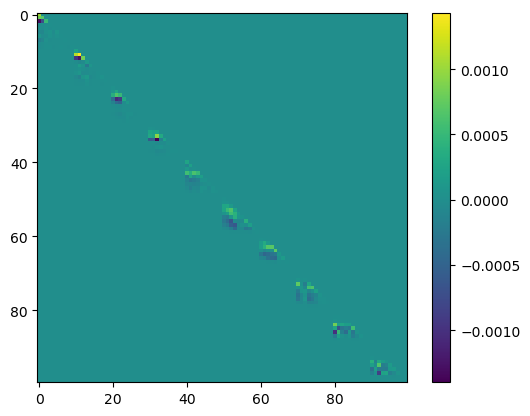

In [30]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(chol)
plt.colorbar()

In [31]:
W_filters = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    W_filters[tracer_name] = model_obj.W

In [36]:
_gp_nzs = {}
for i in range(1000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        nz_mean = model_obj.nz_mean
        nq = model_obj.nqs[i]-model_obj.nq_mean
        W = W_filters[tracer_name]
        nz = nz_mean + np.dot(W, nq)
        z = model_obj.z
        if i == 0:
            _gp_nzs[tracer_name] = [z, nz]
        else:
            _gp_nzs[tracer_name] = [z, np.vstack([_gp_nzs[tracer_name][1], nz])]

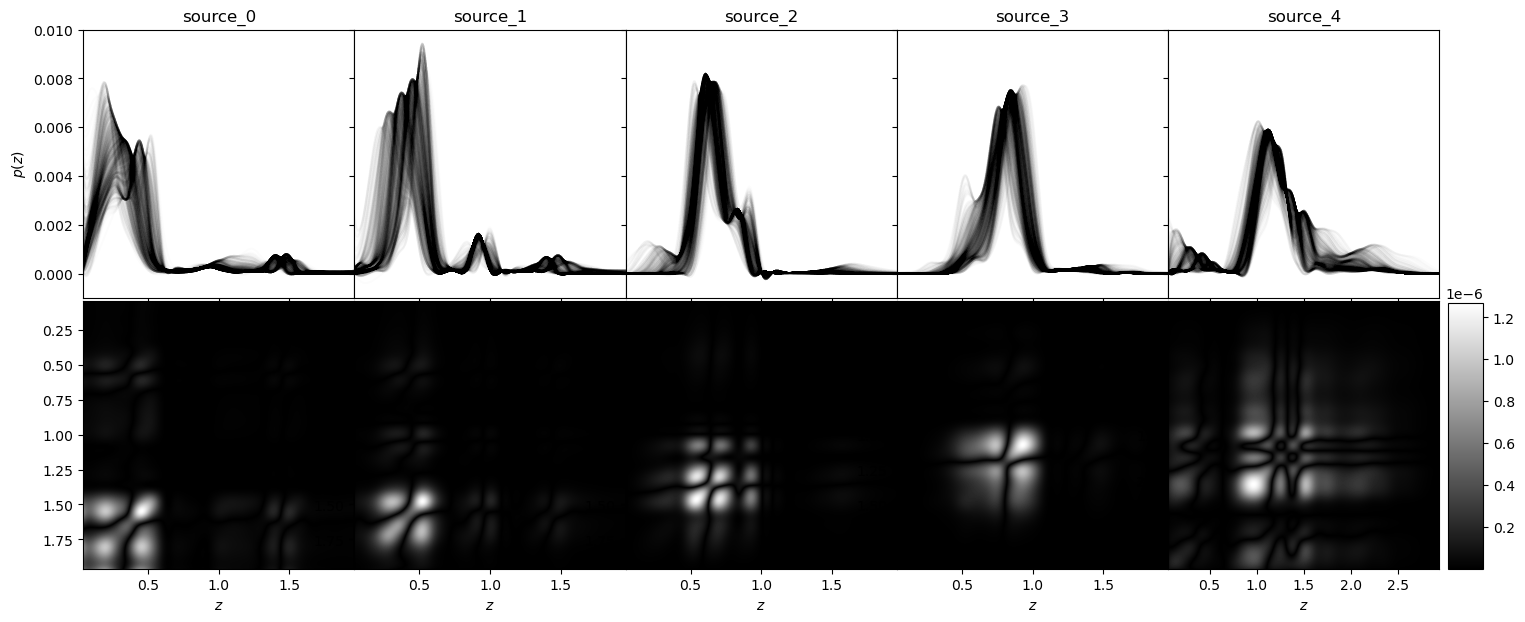

In [37]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(_gp_nzs, plot_tracers)

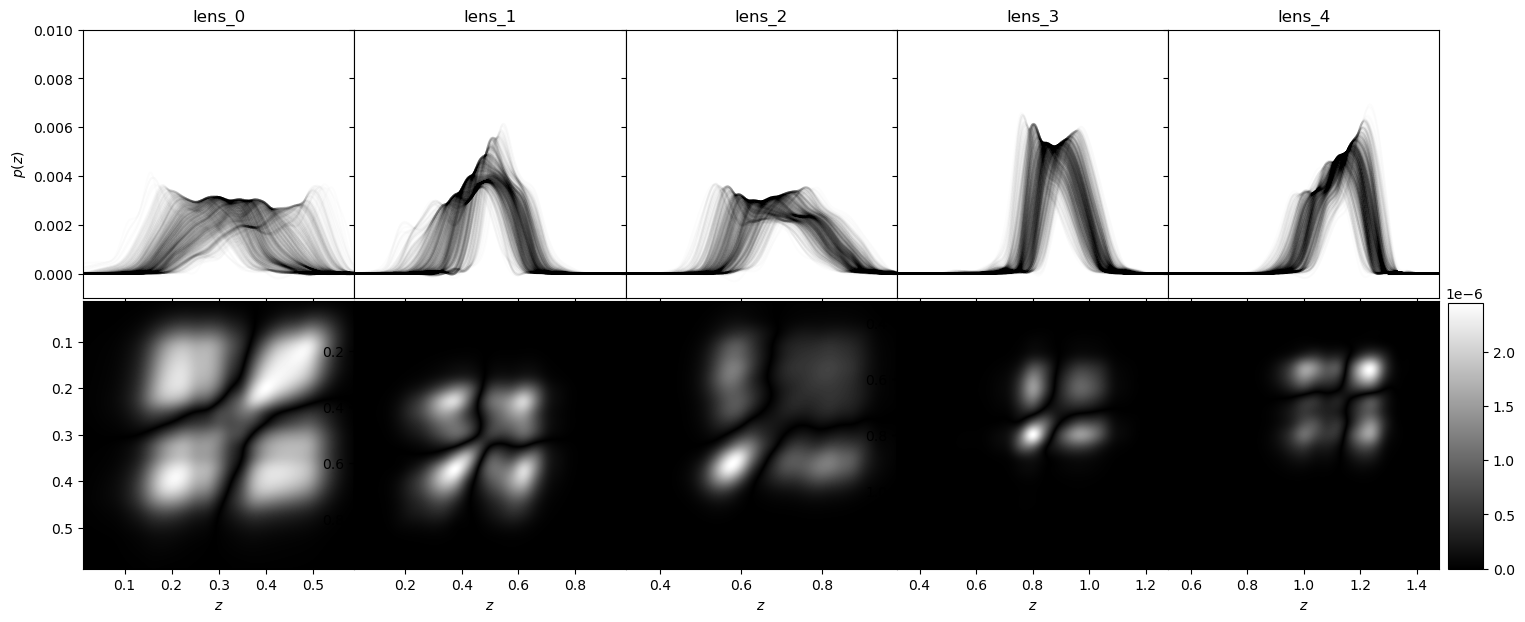

In [38]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(_gp_nzs, plot_tracers)

In [ ]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    print(cov.shape)
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_gp_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, mean=mean, cov=cov, chol=chol)


In [ ]:
#model_objs = gp_priors.model_objs
#for name in list(model_objs.keys()):
#    model_obj = model_objs[name]
#    z = model_obj.z
#    mean = model_obj.nz_mean
#    _, cov, chol = model_obj.get_prior()
#    print(cov.shape)
#    file_name = f"nz_{name}.npz"
#    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}_priors/".format(method) + file_name
#    np.savez(save_to, z=z, dndz=mean, cov=cov)

In [ ]:
#gp_Ds = {}
#for tracer_name in gp_nzs.keys():
#    model_obj = gp_priors.model_objs[tracer_name]
#    base_model_obj = gp_priors_base.model_objs[tracer_name]
#    mu_1, K_1 = base_model_obj.nz_mean, base_model_obj.nz_cov
#    nzs = gp_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    gp_Ds[tracer_name] = np.abs(D)

# PCA

In [ ]:
n = 5
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=n)

In [ ]:
mean, cov, chol = PCA_priors.get_prior()
print(mean)
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(cov)))
plt.colorbar()

In [ ]:
pca_nzs = {}
for i in range(500):
    prior_sample = PCA_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        nz_fid = [model_obj.z, model_obj.nz_mean]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        nz = nzp.pca_model(nz_fid, params, model_obj.eigvecs)[1]
        if i == 0:
            pca_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            pca_nzs[tracer_name] = [nz_fid[0], np.vstack([pca_nzs[tracer_name][1], nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    eigvecs = model_obj.eigvecs
    mean, cov, chol = model_obj.get_prior()
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_PCA_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, mean=mean, cov=np.sqrt(1000)*cov, chol=np.sqrt(1000)*chol, eigvecs=eigvecs)

In [ ]:
#pca_Ds = {}
#for tracer_name in pca_nzs.keys():
#    model_obj = PCA_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = pca_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    pca_Ds[tracer_name] = np.abs(D)

# Comparison

In [ ]:
def make_D_plots(Ds, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*3.5,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tracer_Ds = np.log10(1+np.array([D[key] for D in Ds]))
        axis[i].bar(np.arange(len(Ds)), tracer_Ds)
        axis[i].set_xticks(np.arange(5), ['Shifts', 'ShiftsWidths', 'PCA', 'Comb', 'GP'],
                           rotation=45)
        axis[i].set_title(key)
        if i == 0:
            axis[i].set_ylabel(r'$\log ((1/2)*[D_{KL}(f|g)+D_{KL}(g|f)])$')
        else:
            axis[i].set_yticklabels([])
    plt.show()

In [ ]:
Ds = [shifts_Ds, SnWs_Ds, pca_Ds, gp_Ds]

In [ ]:
make_D_plots(Ds, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'])

In [ ]:
make_D_plots(Ds, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'])